|<div style="width:300px"><img src="https://www.ufz.de/static/custom/weblayout/DefaultInternetLayout/img/logos/ufz_transparent_de_blue.png" width="300"/></div>|<div style="width:300px"><img src="https://discourse.opengeosys.org/uploads/default/original/1X/a288c27cc8f73e6830ad98b8729637a260ce3490.png" width="300"/></div>|<div style="width:330px"><img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="300"/></div>|
|---|---|--:|

# 1D Linear Diffusion

## Analytical Solution

The solution of the diffusion equation for a point x in time t reads:

$ c(x,t) = \left(c_0-c_i\right)\operatorname{erfc}\left(\frac{x}{\sqrt{4Dt}}\right)+c_i$

where $c$ is the concentration of a solute in mol$\cdot$m$^{-3}$, $c_i$ and $c_b$ are initial and boundary concentrations; $D$ is the diffusion coefficient of the solute in water, x and t are location and time of solution. 

In [1]:
import numpy as np
from scipy.special import erfc


# Analytical solution of the diffusion equation
def Diffusion(x, t):
    if (
        not isinstance(t, int)
        and not isinstance(t, np.float64)
        and not isinstance(t, float)
    ):
        # In order to avoid a division by zero, the time field is increased
        # by a small time unit at the start time (t=0). This should have no
        # effect on the result.
        tiny = np.finfo(np.float64).tiny
        t[t < tiny] = tiny

    d = np.sqrt(4 * D * t)
    return (c_b - c_i) * erfc(x / d) + c_i


# Utility-function transforming mass fraction into conctration


def concentration(xm_WL):
    xm_CL = 1.0 - xm_WL
    return xm_CL / beta_c

### Material properties and problem specification

In [2]:
# Henry-coefficient and compressibility of solution
H = 7.65e-6
beta_c = 2.0e-6

# Diffusion coefficient
D = 1.0e-9

# Boundary and initial gas pressures
pGR_b = 9e5
pGR_i = 1e5

# Boundary and initial concentration
c_b = concentration(1.0 - (beta_c * H * pGR_b))
c_i = concentration(1.0 - (beta_c * H * pGR_i))

## Numerical Solution

In [3]:
import os
from pathlib import Path

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

In [4]:
import ogstools as ogs

model = ogs.Project(input_file="diffusion.prj", output_file=f"{out_dir}/modified.prj")
model.replace_text(1e7, xpath="./time_loop/processes/process/time_stepping/t_end")
model.replace_text(
    5e4, xpath="./time_loop/processes/process/time_stepping/timesteps/pair/delta_t"
)
# Write every timestep
model.replace_text(1, xpath="./time_loop/output/timesteps/pair/each_steps")
model.write_input()

# Run OGS
model.run_model(logfile=f"{out_dir}/out.txt", args=f"-o {out_dir} -m .")

OGS finished with project file modified.prj.
Execution took 44.86126470565796 s


In [5]:
# Colors
cls1 = ["#4a001e", "#731331", "#9f2945", "#cc415a", "#e06e85", "#ed9ab0"]
cls2 = ["#0b194c", "#163670", "#265191", "#2f74b3", "#5d94cb", "#92b2de"]

In [6]:
import vtuIO

pvdfile = vtuIO.PVDIO(f"{out_dir}/result_diffusion.pvd", dim=2)

# Get all written timesteps
time = pvdfile.timesteps

# Select individual timesteps for c vs. x plots for plotting
time_steps = [1e6, 2e6, 4e6, 6e6, 8e6, 1e7]

# 'Continuous' space axis for c vs. x plots for plotting
length = np.linspace(0, 1.0, 101)

# Draws a line through the domain for sampling results
x_axis = [(i, 0, 0) for i in length]

# Discrete locations for c vs. t plots
location = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]

In [7]:
# The sample locations have to be converted into a 'dict' for vtuIO
observation_points = {"x=" + str(x): (x, 0.0, 0.0) for x in location}
# Samples concentration field at the observation points for all timesteps

c_over_t_at_x = pvdfile.read_time_series("xmWL", observation_points)
for key in c_over_t_at_x:
    x = c_over_t_at_x[key]
    c_over_t_at_x[key] = concentration(x)

# Samples concentration field along the domain at certain timesteps
c_over_x_at_t = []
for t in range(len(time_steps)):
    c_over_x_at_t.append(
        concentration(
            pvdfile.read_set_data(time_steps[t], "xmWL", pointsetarray=x_axis)
        )
    )

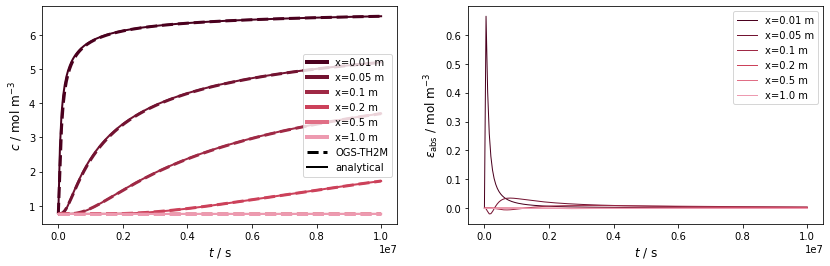

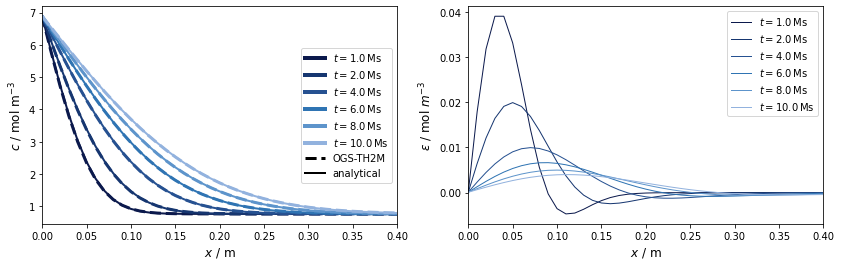

In [8]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 4)

# Plot of concentration vs. time at different locations
fig1, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_xlabel("$t$ / s", fontsize=12)
ax1.set_ylabel("$c$ / mol m$^{-3}$", fontsize=12)

ax2.set_xlabel("$t$ / s", fontsize=12)
ax2.set_ylabel(r"$\epsilon_\mathrm{abs}$ / mol m$^{-3}$", fontsize=12)

label_x = []
for key, _c in c_over_t_at_x.items():
    x = observation_points[key][0]
    label_x.append(key + r" m")
    # numerical solution
    ax1.plot(
        time,
        c_over_t_at_x[key],
        color=cls1[location.index(x)],
        linewidth=3,
        linestyle="--",
    )
    # analytical solution
    ax1.plot(
        time,
        Diffusion(x, time),
        color=cls1[location.index(x)],
        linewidth=2,
        linestyle="-",
    )
    # absolute error
    err_abs = Diffusion(x, time) - c_over_t_at_x[key]
    ax2.plot(
        time,
        err_abs,
        color=cls1[location.index(x)],
        linewidth=1,
        linestyle="-",
        label=key + r" m",
    )


# Hack to force a custom legend:
from matplotlib.lines import Line2D

custom_lines = []

for i in range(6):
    custom_lines.append(Line2D([0], [0], color=cls1[i], lw=4))

custom_lines.append(Line2D([0], [0], color="black", lw=3, linestyle="--"))
custom_lines.append(Line2D([0], [0], color="black", lw=2, linestyle="-"))
label_x.append("OGS-TH2M")
label_x.append("analytical")

ax1.legend(custom_lines, label_x, loc="right")
ax2.legend()
fig1.savefig(f"{out_dir}/diffusion_c_vs_t.pdf")


# Plot of concentration vs. location at different times
fig1, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_xlabel("$x$ / m", fontsize=12)
ax1.set_ylabel("$c$ / mol m$^{-3}$", fontsize=12)
ax1.set_xlim(0, 0.4)

ax2.set_xlabel("$x$ / m", fontsize=12)
ax2.set_ylabel(r"$\epsilon$ / mol $m^{-3}$", fontsize=12)
ax2.set_xlim(0, 0.4)


# Plot concentration over domain at five moments
label_t = []
for t in range(len(time_steps)):
    s = r"$t=$" + str(time_steps[t] / 1e6) + r"$\,$Ms"
    label_t.append(s)
    # numerical solution
    ax1.plot(length, c_over_x_at_t[t], color=cls2[t], linewidth=3, linestyle="--")
    # analytical solution
    ax1.plot(
        length,
        Diffusion(length, time_steps[t]),
        color=cls2[t],
        linewidth=2,
        linestyle="-",
    )
    # absolute error
    err_abs = Diffusion(length, time_steps[t]) - c_over_x_at_t[t]
    ax2.plot(length, err_abs, color=cls2[t], linewidth=1, linestyle="-", label=s)

custom_lines = []

for i in range(6):
    custom_lines.append(Line2D([0], [0], color=cls2[i], lw=4))

custom_lines.append(Line2D([0], [0], color="black", lw=3, linestyle="--"))
custom_lines.append(Line2D([0], [0], color="black", lw=2, linestyle="-"))
label_t.append("OGS-TH2M")
label_t.append("analytical")

ax1.legend(custom_lines, label_t, loc="right")
ax2.legend()

fig1.savefig(f"{out_dir}/diffusion_c_vs_x.pdf")

The numerical approximation approaches the exact solution quite well. Deviations can be reduced if the resolution of the temporal discretisation is increased.